In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPR
import Options

TICKER = 'SPY'

In [2]:
ExpiryDates = yf.Ticker(TICKER).options
print(ExpiryDates)
DateN = 2
options = yf.Ticker(TICKER).option_chain(ExpiryDates[DateN])
Calls = options.calls
Puts = options.puts
current_price = yf.Ticker(TICKER).history(period='1d')['Close'][0]
K = Calls['strike']
k = np.log(Calls['strike'] / current_price)


('2025-10-08', '2025-10-09', '2025-10-10', '2025-10-13', '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17', '2025-10-24', '2025-10-31', '2025-11-07', '2025-11-14', '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-01-30', '2026-02-20', '2026-02-27', '2026-03-20', '2026-03-31', '2026-06-18', '2026-06-30', '2026-09-18', '2026-09-30', '2026-12-18', '2027-01-15', '2027-12-17', '2028-01-21')


C:\Users\adamd\AppData\Local\Temp\ipykernel_26104\4272614368.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = yf.Ticker(TICKER).history(period='1d')['Close'][0]


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 7.0596643249177036e-06
        x: [-1.067e-01  2.029e-01 -1.191e-01 -3.460e-02  5.300e-01]
      nit: 87
      jac: [ 1.008e-03  5.064e-04  7.221e-06  2.490e-05  2.122e-04]
     nfev: 678
     njev: 113
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
Fitted SVI parameters: a=-0.10671928291927943, b=0.2029236678440793, rho=-0.11909468845827215, m=-0.03460299904439191, sigma=0.5299843770239654


C:\Projects\Quant\Quant\Options.py:296: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(svi(np.log(K / S), *result.x) / T)


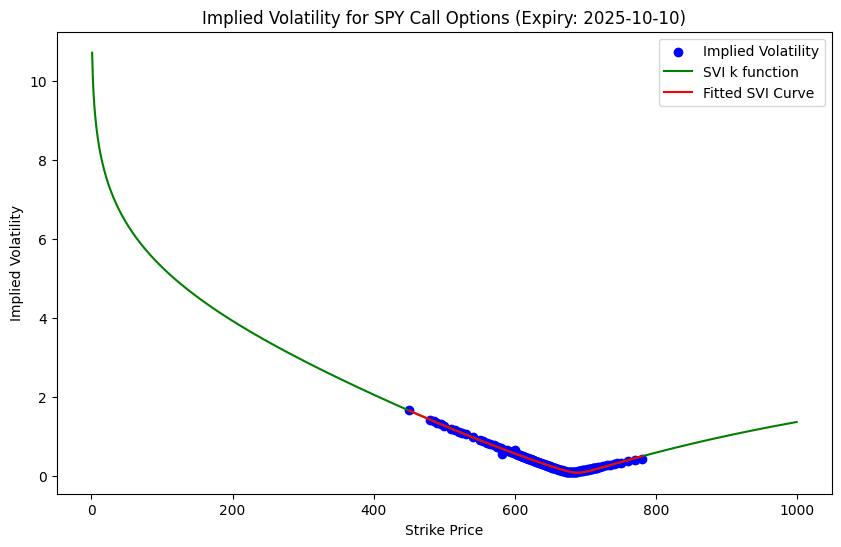

In [3]:
CallOptions = pd.DataFrame({
    'Strike': Calls['strike'],
    'bid': Calls['bid'],
    'ask': Calls['ask'],
    'Price': (Calls['bid'] + Calls['ask']) / 2,
    'Type': 'C',
    'Expiry': pd.to_datetime(ExpiryDates[3]),
    'Spot': current_price,
    'Rate': 0.04
})
CallOptions['Implied Volatility'] = Options.BS_Implied_Volatility(CallOptions)
K = np.arange(0, 1000, 1)

plt.figure(figsize=(10, 6))
plt.scatter(CallOptions['Strike'], CallOptions['Implied Volatility'], color='blue', label='Implied Volatility')
plt.title(f'Implied Volatility for {TICKER} Call Options (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

# fit to SVI curve
result, svi_curve, svi_k = Options.fit_IV_slice(CallOptions)
plt.plot(K, svi_k(K), color='green', label='SVI k function')
plt.plot(CallOptions['Strike'], svi_curve, color='red', label='Fitted SVI Curve')
plt.legend()
plt.show()



C:\Projects\Quant\Quant\Options.py:315: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * svi_k(K)**2) * T) / (svi_k(K) * np.sqrt(T))
C:\Projects\Quant\Quant\Options.py:296: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(svi(np.log(K / S), *result.x) / T)
C:\Projects\Quant\Quant\Options.py:315: RuntimeWarning: invalid value encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * svi_k(K)**2) * T) / (svi_k(K) * np.sqrt(T))
C:\Projects\Quant\Quant\Options.py:317: RuntimeWarning: invalid value encountered in multiply
  return np.exp(-r * T) * norm.pdf(d2) / (K**2 * svi_k(K) * np.sqrt(T))


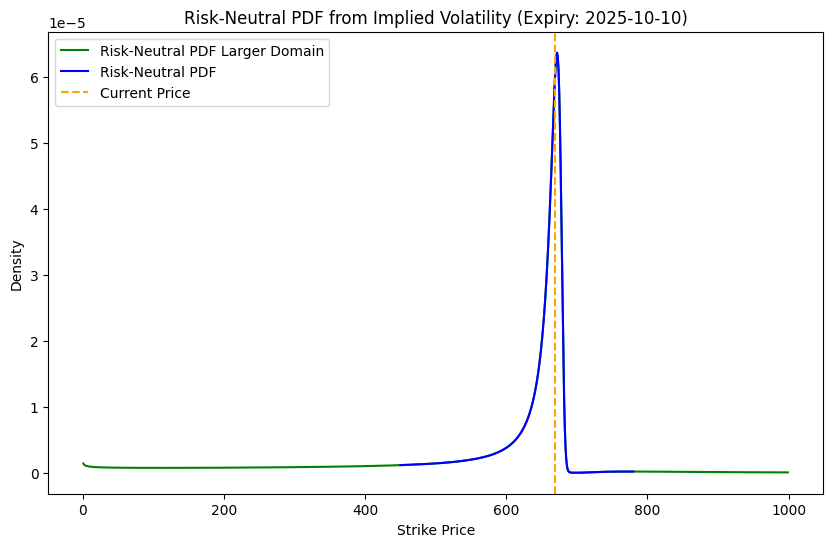

In [ ]:
P, P_k = Options.Distribution_from_IV(CallOptions, svi_curve, svi_k)

plt.figure(figsize=(10, 6))
plt.plot(K, P_k(K), color='green', label='Risk-Neutral PDF Larger Domain')
plt.plot(CallOptions['Strike'], P, color='blue', label='Risk-Neutral PDF')
plt.axvline(x=current_price, color='orange', linestyle='--', label='Current Price')
plt.axhline(y=0, color='black', linestyle='-')
plt.title(f'Risk-Neutral PDF from Implied Volatility (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Density')
plt.legend()
plt.show()

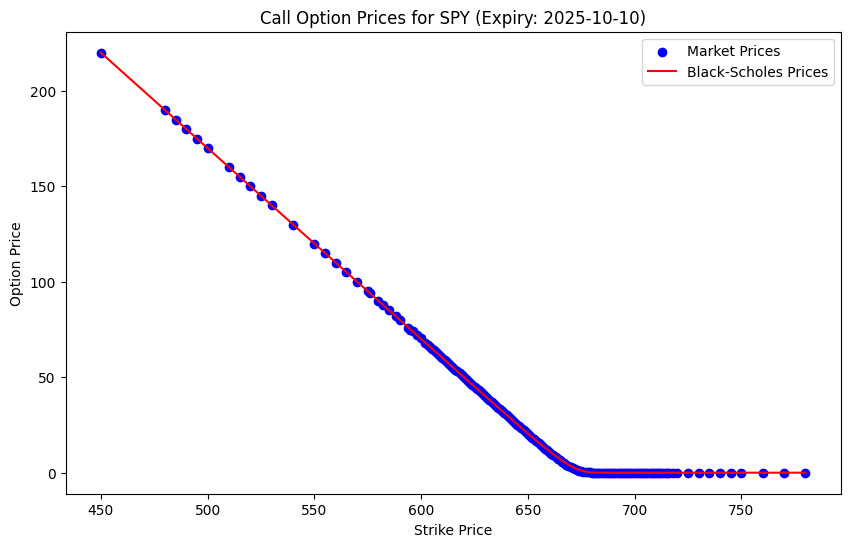

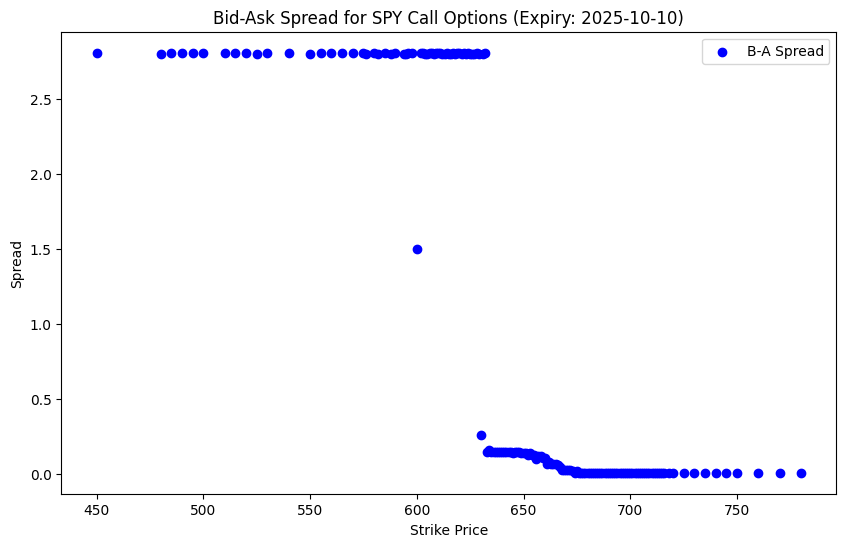

In [5]:
BS_Call_Prices = Options.BS_Option_Price(CallOptions, svi_curve)

plt.figure(figsize=(10, 6))
plt.scatter(CallOptions['Strike'], CallOptions['Price'], color='blue', label='Market Prices')
plt.plot(CallOptions['Strike'], BS_Call_Prices, color='red', label='Black-Scholes Prices')
plt.title(f'Call Option Prices for {TICKER} (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(CallOptions['Strike'], CallOptions['ask']-CallOptions['bid'], color='blue', label='B-A Spread')
plt.title(f'Bid-Ask Spread for {TICKER} Call Options (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [6]:

# print(Calls)

# Find Characteristic Function of Underlying Asset Return Distribution
# Phi = -u^2 * int(exp(iuK) * C(K) dK) 
import torch
K = torch.tensor(K.values, dtype=torch.float32)
C = torch.tensor(Calls['lastPrice'].values, dtype=torch.float32)

# interpolate to evenly spaced grid
NPoints = 2**10
K = torch.linspace(650, 700, NPoints)
from scipy.interpolate import interp1d
C = interp1d(Calls['strike'], Calls['lastPrice'], bounds_error=False, fill_value="extrapolate")(K)
C = torch.tensor(C, dtype=torch.float32)
dK = K[1] - K[0]

du = 2 * np.pi / (NPoints * dK)
u = torch.fft.fftshift(torch.fft.fftfreq(NPoints, d=dK)) * 2 * torch.pi
C_fft = torch.fft.fftshift(torch.fft.fft(torch.fft.ifftshift(C))) * dK
C_kk_rec = torch.fft.fftshift(torch.fft.ifft(torch.fft.ifftshift(- u**2 * C_fft))) * NPoints * du / (2 * np.pi)
C_kk_rec = C_kk_rec.real

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(K, C, label='Call Prices C(K)')
plt.title('Data Call Prices C(K)')
plt.xlabel('K')
plt.ylabel('C(K)')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(u, torch.real(C_fft), label='Re(φ(u))')
plt.plot(u, torch.imag(C_fft), label='Im(φ(u))')
plt.title('Fourier Transform φ(u)')
plt.xlabel('u')
plt.ylabel('φ(u)')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(K, C_kk_rec, label='Reconstructed d2C(K)/dK2', linestyle='--')
plt.title('Reconstructed Function d2C(K)/dK2')
plt.xlabel('K')
plt.ylabel('d2C(K)/dK2')
plt.ylim(-10, 10)
plt.legend()
plt.tight_layout()
plt.show()


mu, COV, mu_xx = GPR.fit_option_price(Calls['strike'], Calls['lastPrice'], current_price)
f, h, w = Options.fit_option_price_hermite(Calls['strike'], Calls['lastPrice'], current_price, N = 7, w0=np.array([1, 0, 1, 0, 1, 0, 1]))


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(K, Calls['lastPrice'], color='blue', label='Call Prices')
plt.plot(K, mu, color='red', label='GPR Mean')
plt.plot(K, f, color='green', label='Options Fit')
plt.axvline(x=current_price, color='orange', linestyle='--', label='Current Price')
plt.legend()
plt.title(f'GPR Fit to {TICKER} Call Option Prices (Expiry: {ExpiryDates[3]})')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.show()

plt.figure(figsize=(10, 6))
# plt.plot(K, mu_xx, color='orange', label='d2mu/dK2')
# mu_xx = np.maximum(mu_xx, 0) / np.abs(np.trapezoid(Calls['strike'].values, np.maximum(mu_xx, 0)))  # Ensure non-negativity & Normalize
# plt.plot(K, mu_xx, color='green', label='Non-negative d2mu/dK2')
plt.plot(K, h**2, color='purple', label='d2F/dK2')
plt.plot(K, h**2 / np.abs(np.trapezoid(K, h**2)), color='red', label='Normalized d2F/dK2')
plt.axvline(x=current_price, color='orange', linestyle='--', label='Current Price')
plt.plot(K, h, color='blue', label='h(K)')
plt.title(f'Second Derivative of Option Price Fit (Expiry: {ExpiryDates[3]})')
plt.xlabel('Strike Price')
plt.ylabel('Second Derivative')
plt.legend()
plt.show()

